In [40]:
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as tfs
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

data_tfs = tfs.Compose([tfs.ToTensor(),
                        tfs.Normalize((0.5),(0.5))])

root = './data'

train = MNIST(root, train=True, transform=data_tfs, download=True)
test = MNIST(root, train=False, transform=data_tfs, download=True)

print(train)
print(test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


60 000 изображений для обучения. 10 000 для тестирования.

In [32]:
print(type(train[0]))
print(train[0][0].shape)
print(type(train[0][1]))

<class 'tuple'>
torch.Size([1, 28, 28])
<class 'int'>


Данные хранятся в картеже формат (тензор, ярлык класса).
Размер изображение (канал, длина, высота).
Ярлык записан целой цифрой.

In [33]:
batch_size = 128

train_loader = DataLoader(train, batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size, drop_last=True)
print(type(train_loader))

x_batch, y_batch = next(iter(train_loader))
print(x_batch.shape, y_batch.shape)

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([128, 1, 28, 28]) torch.Size([128])


Сделали размер пакета 128 картинок.
Размер пакета с картинками (кол-во картинок, канал, длина, высота)
Размер пакета с ярлыками (кол-во ярлыков)

 ### Модель и обучение

In [34]:
features = 28*28
classes = 10
print(f'Features = {features} \nClasses = {classes}')

Features = 784 
Classes = 10


In [35]:
W = torch.FloatTensor(features, classes).uniform_(-1) / features ** 0.5
W.requires_grad = True
W.shape

torch.Size([784, 10])

SGD (стохастические градиентный спуск) цикл обучения

In [37]:
epochs = 3
learning_rate = 0.01
loss_function = torch.nn.CrossEntropyLoss()
history = []


for i in range(epochs):
  for x_batch, y_batch in train_loader:

    # загружаем батч данных (вытянутый в линию)
    x_batch = x_batch.reshape(x_batch.shape[0], -1)

    # вычисляем функцию потерь (log loss, также известная как кросс-энтропия)
    logits = x_batch @ W
    probabilities = torch.exp(logits) / torch.exp(logits).sum(dim=1, keepdims=True)

    loss = -torch.log(probabilities[range(batch_size), y_batch]).mean()
    history.append(loss.item())

    # вычисляем градиенты
    loss.backward()

    # делаем шаг градиентного спуска
    grad = W.grad
    with torch.no_grad():
      W -= learning_rate * grad
    W.grad.zero_()

  print(f'{i+1},\t loss: {history[-1]}')


1,	 loss: 0.191525399684906
2,	 loss: 0.1368894875049591
3,	 loss: 0.11731445044279099


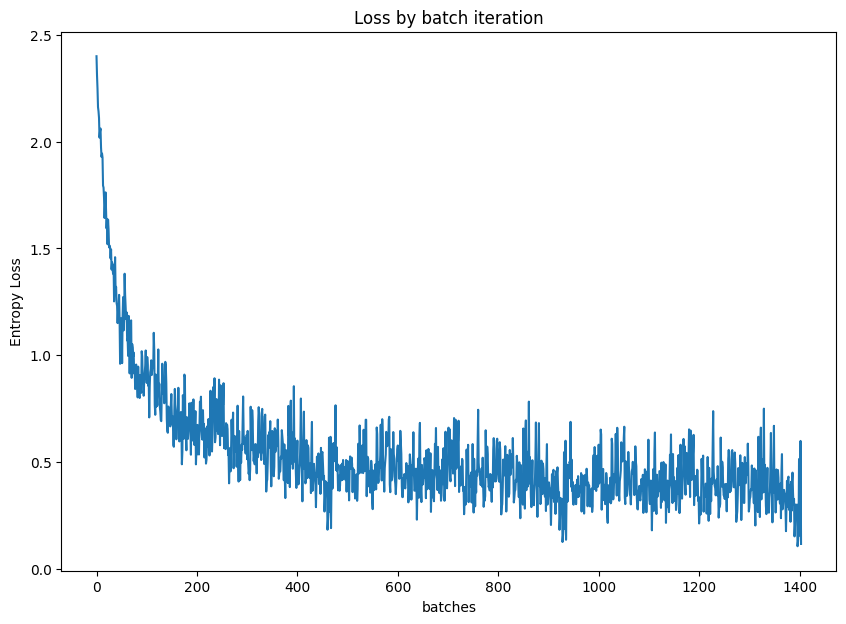

In [38]:
plt.figure(figsize=(10,7))
plt.plot(history)
plt.title('Loss by batch iteration')
plt.xlabel('batches')
plt.ylabel('Entropy Loss')
plt.show()

In [53]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1)

  preds = torch.argmax(x_batch.mm(W), dim=1)
  acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.4}')

Test accuracy 0.8999


### Теперь реализуем с помощью класса